In [1]:
import os
import pandas as pd 
import numpy as np 
from astropy.coordinates import SkyCoord  
import astropy.units as u

# visualisation
import matplotlib.pylab as plt
import matplotlib.font_manager as fm

# our scripts 
import src.processing as sp 
import settings as st
import utils.helpers as hp
import utils.imaging as ui

# Volunteers Votes

In [2]:
dataframe = hp.load_csv(st.ZENODO, 'gz_decals_volunteers_5')

In [3]:
dataframe.head()

,iauname,ra,dec,redshift,elpetro_absmag_r,sersic_nmgy_r,petro_th50,petro_th90,petro_theta,upload_group,...,merging_minor-disturbance_fraction,merging_minor-disturbance_debiased,merging_major-disturbance,merging_major-disturbance_fraction,merging_major-disturbance_debiased,merging_merger,merging_merger_fraction,merging_merger_debiased,wrong_size_statistic,wrong_size_warning
0,J112953.88-000427.4,172.474526,-0.074281,0.124142,-21.253342,167.262880,1.835066,5.414066,4.202472,pre_active,...,0.100,0.127708,5,0.0625,0.076923,0,0.000000,0.000000,133.592684,False
1,J104325.29+190335.0,160.856533,19.060441,0.049088,-21.775410,2941.729200,4.405412,14.320828,10.757237,targeted,...,0.000,0.000000,0,0.0000,0.000000,2,0.057143,0.060757,132.443129,False
2,J104629.54+115415.1,161.623135,11.904197,0.092906,-19.947397,125.076324,4.719870,13.139816,9.726173,active_baseline,...,0.200,NaN,0,0.0000,NaN,0,0.000000,NaN,156.336302,False
3,J082950.68+125621.8,127.461190,12.939386,0.066619,-19.800629,173.592030,2.929065,7.224961,6.528331,active_baseline,...,0.125,NaN,0,0.0000,NaN,0,0.000000,NaN,155.386379,False
4,J122056.00-015022.0,185.233342,-1.839340,0.070042,-19.013256,88.826880,2.521897,6.496888,5.054409,active_baseline,...,0.000,NaN,0,0.0000,NaN,0,0.000000,NaN,143.735491,False


# Plot Position on Sky

In [5]:
xarr, yarr = dataframe.ra.values, dataframe.dec.values

In [6]:
eq = SkyCoord(xarr, yarr, unit=u.deg)
gal = eq.galactic

In [7]:
colors = np.random.random((len(xarr), 3))

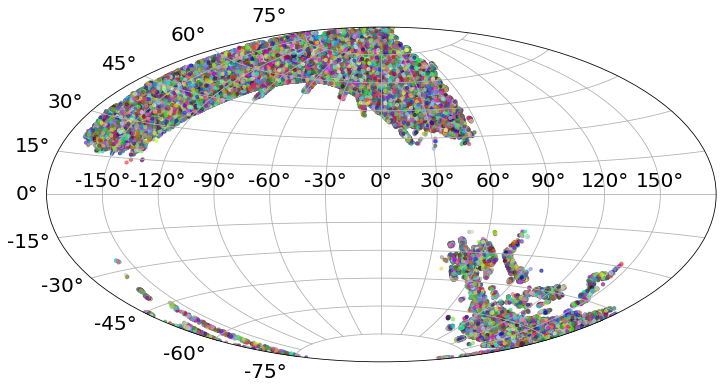

In [9]:
plt.figure(figsize = (12, 8))
plt.subplot(111, projection='aitoff')
plt.grid(True)
plt.scatter(gal.l.wrap_at('180d').radian, gal.b.radian, s=10, c=colors, alpha=0.6, edgecolors=colors, rasterized=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.savefig('plots/skymap.pdf', bbox_inches = 'tight')
plt.show()

### Correct for the locations of the images 

In [3]:
# dr5_desc = sp.correct_location('gz_decals_volunteers_5', save = True, filename='dr5_votes')

### The data with the votes

In [2]:
dataframe = hp.read_parquet(st.DATA_DIR, 'descriptions/dr5_votes')

In [3]:
labels = sp.generate_labels(dataframe, save=False)

In [5]:
# labels.to_csv('ml/labels.csv')

### Split into train, test and validate

In [8]:
train_val_test = sp.split_data(labels, 0.05, 0.15, save=False)

In [9]:
train_val_test['train'].shape

(202628, 36)

In [10]:
train_val_test['validate'].shape

(12665, 36)

In [11]:
train_val_test['test'].shape

(37993, 36)

### Calculate the weights per class

In [5]:
labels_num = labels.iloc[:,2:]
weights = labels_num.sum(axis=0)
inv_weights = 1/weights
inv_weights_norm = inv_weights/inv_weights.sum()

# Pie Chart

In [11]:
from src.plots import calc_percent_task
from src.plots import plot_pie

In [12]:
dataframe = pd.read_csv('ml/labels.csv')

In [14]:
percentage = [calc_percent_task(dataframe, i + 1) for i in range(10)]

In [27]:
# for i in range(10):
#     plot_pie(percentage, i, True)

In [12]:
labels.shape

(253286, 36)

# Metrics for ML and MTL network

In [53]:
from src.postprocess import metric_multitask, metric_multilabel

In [15]:
hl_class_ml, hl_ml = metrics_multilabel('ML_predictions_class', 'test')

Smooth                        : 0.138
Featured or Disk              : 0.143
Artifact                      : 0.029
Round                         : 0.133
In Between                    : 0.200
Cigar Shaped                  : 0.069
Edge On Disk (Yes)            : 0.099
Edge On Disk (No)             : 0.253
Merging (Merger)              : 0.073
Merging (Major Disturbance)   : 0.047
Merging (Minor Disturbance)   : 0.109
Merging (None)                : 0.133
Bulge (Rounded)               : 0.188
Bulge (Boxy)                  : 0.034
Bulge (None)                  : 0.072
No Bar                        : 0.341
Weak Bar                      : 0.137
Strong Bar                    : 0.060
Spiral Arms (Yes)             : 0.131
Spiral Arms (No)              : 0.360
Spiral Winding (Tight)        : 0.149
Spiral Winding (Medium)       : 0.133
Spiral Winding (Loose)        : 0.091
Spiral Arms (1)               : 0.035
Spiral Arms (2)               : 0.146
Spiral Arms (3)               : 0.031
Spiral Arms 

In [54]:
hl_class_mtl, hl_task_mtl = metric_multitask('MTL_predictions_targets_mtl-models-2022-6-14', 'test')

Overall Hamming loss is: 0.153
--------------------------------------------------
Task  1: 0.127
Task  2: 0.295
Task  3: 0.193
Task  4: 0.135
Task  5: 0.106
Task  6: 0.187
Task  7: 0.273
Task  8: 0.127
Task  9: 0.084
Task 10: 0.144
--------------------------------------------------
Smooth                        : 0.154
Featured or Disk              : 0.145
Artifact                      : 0.081
Round                         : 0.201
In Between                    : 0.513
Cigar Shaped                  : 0.170
Edge On Disk (Yes)            : 0.113
Edge On Disk (No)             : 0.273
Merging (Merger)              : 0.131
Merging (Major Disturbance)   : 0.060
Merging (Minor Disturbance)   : 0.180
Merging (None)                : 0.172
Bulge (Rounded)               : 0.194
Bulge (Boxy)                  : 0.038
Bulge (None)                  : 0.085
No Bar                        : 0.360
Weak Bar                      : 0.138
Strong Bar                    : 0.061
Spiral Arms (Yes)             : 0

# Predictions for ML

In [1]:
import torch
import torch.nn as nn 
from src.network import MultiLabelNet
from src.dataset import DECaLSDataset
from torch.utils.data import DataLoader
import settings as st
import numpy as np 

from src.postprocess import compare_labels_ml
import utils.helpers as hp
import os
from PIL import Image
import matplotlib.pylab as plt

In [2]:
test_dataset = DECaLSDataset(mode='test', augment=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

The number of test points is 37993


In [3]:
pred = hp.load_csv('results', 'ML_predictions_class')
test = hp.load_csv('ml', 'test')

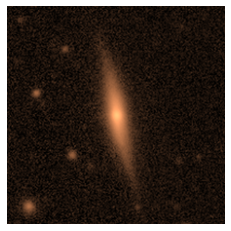

Predictions
-----------
Tag  0: Featured or Disk
Tag  1: Cigar Shaped
Tag  2: Edge On Disk (Yes)
Tag  3: Merging (None)
Tag  4: Bulge (Rounded)

Volunteers
----------
Tag  0: Featured or Disk
Tag  1: Cigar Shaped
Tag  2: Edge On Disk (Yes)
Tag  3: Merging (None)
Tag  4: Bulge (Rounded)


In [13]:
# 8501
# 1410
labels_test, labels_pred = compare_labels_ml(test_loader, 1410, pred, savefig = True)

# Build the Tree

In [1]:
import settings as st 
import utils.helpers as hp
from src.postprocess import build_tree

In [2]:
date = '2022-6-14'

In [3]:
preds = hp.load_pickle('results', 'MTL_predictions_mtl-models-'+date)
test = hp.load_csv('ml', 'test')

In [4]:
# tree_pred, tree_test = build_tree(test, preds, save=False, fname=date)

# Visualise Image and Tree

In [9]:
import pandas as pd 
from torch.utils.data import DataLoader
from src.dataset import DECaLSDataset
from src.postprocess import compare_tree_mtl

In [10]:
date = '2022-6-14'
tree_pred_df = pd.read_csv('results/tree_pred-'+date+'.csv')
tree_test_df = pd.read_csv('results/tree_test-'+date+'.csv')

In [11]:
test_dataset = DECaLSDataset(mode='test', augment=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

The number of test points is 37993


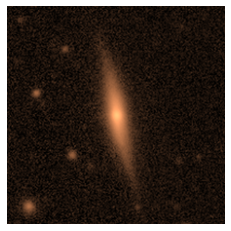

Predictions
-----------
                          1410
task_1    ['Featured or Disk']
task_3  ['Edge On Disk (Yes)']
task_4      ['Merging (None)']
task_5     ['Bulge (Rounded)']

Volunteers
----------
                          1410
task_1    ['Featured or Disk']
task_3  ['Edge On Disk (Yes)']
task_4      ['Merging (None)']
task_5     ['Bulge (Rounded)']


In [14]:
labels_pred, labels_test = compare_tree_mtl(test_loader, 1410, tree_pred_df, tree_test_df, savefig=True)

# Main Script for Distance Calculation

In [39]:
import os
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import matplotlib.pylab as plt 
import matplotlib as cm

from src.fewshot import ml_backbone
from src.ranking import mtl_backbone_decoders
from src.ranking import calculate_distance_ml
from src.ranking import calculate_distance_mtl
from src.ranking import visualise_neighbour
from src.dataset import DECaLSDataset
from src.clustering import name_to_id

In [2]:
test_dataset = DECaLSDataset(mode='test', augment=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

The number of test points is 37993


### Backbone for Multi-Label Network

In [5]:
back_ml = ml_backbone('ml-models-2022-5-25/resnet_18_multilabel_29.pth')

### Backbone for Multi-Task Network

In [4]:
back_mtl, dec_mtl = mtl_backbone_decoders('mtl-models-2022-6-14/resnet_18_multitask_29.pth')

### Visualise Reference Image

In [41]:
ref_id = name_to_id(test_loader, 'J101256.89-002800.0')

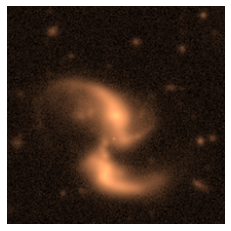

In [42]:
name = 'copper'
plt.figure(figsize = (4,4))
plt.imshow(test_loader.dataset[ref_id][0].permute(1, 2, 0), cmap=plt.get_cmap(name))
plt.axis('off')
plt.show()

### Distance Using MTL

In [19]:
# CHECK Python Script: We are using only top 100 images (pairwise distance calculation takes time)
d_mtl = calculate_distance_mtl(back_mtl, dec_mtl, ref_id, test_loader, pnorm = 1, save = False) 

### Distance Using ML

In [36]:
# # CHECK Python Script: We are using only top 100 images (pairwise distance calculation takes time)
d_ml = calculate_distance_ml(back_ml, ref_id, test_loader, pnorm = 1, save = False)

### Visualise Nearest Objects

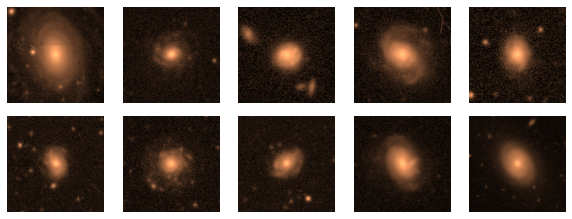

In [43]:
visualise_neighbour(d_ml, test_loader, 10, multilabel=True, save = False, ref_id = ref_id)

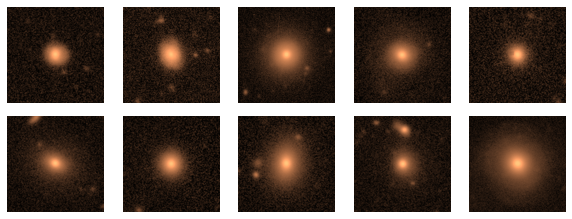

In [22]:
visualise_neighbour(d_mtl, test_loader, 10, multilabel=False, save = False, ref_id = ref_id)

# Clustering

The idea is to use clustering to generate the baskets. 

In [1]:
from torch.utils.data import DataLoader

from src.fewshot import ml_backbone
from src.dataset import DECaLSDataset
from src.clustering import cluster_embeddings, cluster_kmeans, cluster_copy_images
import settings as st

### Load the test data

In [2]:
test_dataset = DECaLSDataset(mode='test', augment=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

The number of test points is 37993


### Backbone for Multi-Label Network

In [3]:
back_ml = ml_backbone('ml-models-2022-5-25/resnet_18_multilabel_29.pth')

Calculate the embeddings in the test set. 

In [4]:
embeddings = cluster_embeddings(back_ml, test_loader, save=True)

Apply $k-$means clustering.

In [5]:
combined = cluster_kmeans(test_loader, embeddings, save=True)

running k-means on cuda..


[running kmeans]: 23it [00:00, 34.40it/s, center_shift=0.000000, iteration=23, tol=0.000100]


Copy images to the respective folders. 

In [6]:
cluster_copy_images(combined)

# Few Shot Learning

- Copy a few examples (50) of images from the same class in the images/class/ folder. 
- Manually select N examples (high purity samples). 
- Generate the embedding vectors for these images. 
- Calculate the mean of the embedding vectors per class.

Then we have two options:
- Use a nearest neightbour classifier (straightforward)
- Use meta-learning approach 

#### Nearest Neighbour Classifier 
- Normalise the vector properly. 

#### Meta-Learning
- Use this vector to initialise the weights for fine-tuning. 
- Train a classifier with cross-entropy loss (with an entropy regulariser). 

## The main algorithm

In [1]:
from torch.utils.data import DataLoader
from src.fewshot import ml_backbone, distance_support_query
from src.fewshot import ml_feature_extractor, copy_image_fewshot
from src.fewshot import targets_support_query, generate_labels_fewshot
from src.dataset import FSdataset

import settings as st 

In [8]:
## copy the images of the same class to a folder 
# copy_image_fewshot(nobjects = 200, threshold = 0.70)

## make the manual selection of images 

## Copy Query Images OR Choose them 
## query, subset = copy_query_images(10, True)
# query_train, subset_train = targets_support_query(10, save = True, train = True) # if we carefully select the images 
# query_valid, subset_valid = targets_support_query(10, save = True, train = False) 

# # Generate the labels 
# query_train, support_train = generate_labels_fewshot(10, save = True, train = True)
# query_valid, support_valid = generate_labels_fewshot(10, save = True, train = False)

# # get the model 
# model = ml_backbone("ml-models-2022-5-25/resnet_18_multilabel_29.pth")

# # generate the dataloaders

# dataloaders_train = dict()
# dataloaders_valid = dict()

# for col in st.FS_CLASSES:
#     fs_subset_train = FSdataset(support=True, objtype = col, nshot = 10, train = True)
#     fs_subset_valid = FSdataset(support=True, objtype = col, nshot = 10, train = False)
#     dataloaders_train[col] = DataLoader(dataset=fs_subset_train, batch_size=1, shuffle=False)
#     dataloaders_valid[col] = DataLoader(dataset=fs_subset_valid, batch_size=1, shuffle=False)

# # extract the embeddings
# vectors, vectors_mean = ml_feature_extractor(model, dataloaders_train, save = True, train = True)
# vectors, vectors_mean = ml_feature_extractor(model, dataloaders_train, save = True, train = False)

# calculate the distance between the query image and the support set 
# combined_train = distance_support_query("ml-models-2022-5-25/resnet_18_multilabel_29.pth", nshot=10, save = True, train = True)
# combined_valid = distance_support_query("ml-models-2022-5-25/resnet_18_multilabel_29.pth", nshot=10, save = True, train = False)

The shape of the supports embeddings is 4 x 1000
The shape of the supports embeddings is 4 x 1000


## Work with Embedding vectors

Note that it is not entirely true that a label can be assigned to a galaxy. The following serves as an illustration only. In practice, the idea is to show the model "similar classes of objects" (for example, 10 images/shots/examples in the Support Set) and the query image/object is then assigned to each class depending on the highest probability. 

### Nearest Neighbour Approach

In [1]:
from src.fewshot import distance_support_query

In [2]:
combined = distance_subset_query("ml-models-2022-5-25/resnet_18_multilabel_29.pth", nshot=10, save = True)

The shape of the subsets embeddings is 4 x 1000


In [4]:
combined.head()

,Objects,True Labels,Predicted Labels
0,J081815.33+162408.9.png,Artifact,Cigar-Shaped
1,J110602.51+305001.0.png,Artifact,Artifact
2,J114717.76+124048.7.png,Artifact,Artifact
3,J093747.60+273412.0.png,Artifact,Merging-Merger
4,J133723.71+243710.8.png,Artifact,Artifact


### Transductive Fine Tuning

NOTE: We have made a copy of the model in the following folder:

/data/phys-zooniverse/phys2286/ml-model-fewshot-ft/

with the filename resnet_18_multilabel_29.pth. 

We will finetune this model and store it under a different name. 

Below is a flow for the algorithm. 

In [1]:
# from src.fewshot import generate_labels_fewshot
# from src.dataset import FewShotFineTuneData
 
## Generate the labels for the support set (done only once)
# query, support = generate_labels_fewshot(nshot = 10, save = True)

## The dataloaders for the support and query sets 
# support_dataset = FewShotFineTuneData(support=True, nshot=10)
# support_loader = DataLoader(dataset=support_dataset, batch_size=1, shuffle=True)

# query_dataset = FewShotFineTuneData(support=False, nshot=10)
# query_loader = DataLoader(dataset=query_dataset, batch_size=1, shuffle=True)

In [5]:
import datetime
import torch.nn as nn
from torch.utils.data import DataLoader

# our scripts and functions
import settings as st
from src.fewshot import ml_backbone, normalise_weights
from src.fewshot import finetuning_predictions, training_finetune
from src.dataset import FewShotFineTuneData
from src.network import FineTuneNet


DATE = datetime.datetime.now()
TODAY = str(DATE.year) + '-' + str(DATE.month) + '-' + str(DATE.day)
NSHOT = 10

### Backbone

In [3]:
fname = 'ml-models-2022-5-25/resnet_18_multilabel_29.pth'
backbone = ml_backbone(fname)

### Dataloader

In [4]:
support_dataset = FewShotFineTuneData(support=True, nshot=10)
support_loader = DataLoader(dataset=support_dataset, batch_size=1, shuffle=True)

query_dataset = FewShotFineTuneData(support=False, nshot=10)
query_loader = DataLoader(dataset=query_dataset, batch_size=1, shuffle=True)

### Full Model

In [6]:
%%capture
nshot = 10
weights_norm = normalise_weights('fewshot', f'vectors_mean_{str(nshot)}')
model_ft = FineTuneNet(backbone, True, weights_norm)
model_ft.to(st.DEVICE)

### Training

In [7]:
quant = {'lr': 1E-3, 
        'weight_decay': 1E-5, 
        'coefficient': 0.01,
        'nepochs': 150,
        'criterion': nn.CrossEntropyLoss()}

loaders = {'support': support_loader, 
          'query': query_loader}

In [ ]:
# this is doing the training part of the finetuning procedure
# model = training_finetune(model_ft, loaders, quant, save = True)

In [9]:
combined = finetuning_predictions(model, query_loader, nshot, False)

In [10]:
combined.head()

,Objects,True Labels,Predicted Labels
0,J081815.33+162408.9.png,Artifact,Cigar-Shaped
1,J110602.51+305001.0.png,Artifact,Artifact
2,J114717.76+124048.7.png,Artifact,Artifact
3,J093747.60+273412.0.png,Artifact,Artifact
4,J133723.71+243710.8.png,Artifact,Artifact


In [9]:
import utils.helpers as hp
import matplotlib.pylab as plt 

In [15]:
loss_train = hp.load_pickle('results', 'loss_finetune_train_2022-8-31_300')
loss_valid = hp.load_pickle('results', 'loss_finetune_valid_2022-8-31_300')

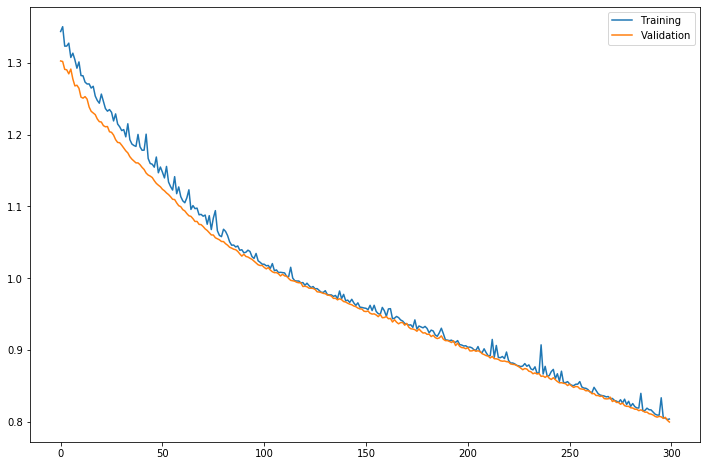

In [16]:
plt.figure(figsize = (12, 8))
plt.plot(range(len(loss_train)), loss_train, label = 'Training')
plt.plot(range(len(loss_valid)), loss_valid, label = 'Validation')
plt.legend()
plt.show()